In [1]:
!pip install tensorflow-hub
!pip install numpy==1.16.1
#!pip install keras==2.1.2

from __future__ import print_function
import math
import pickle

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras.backend as K
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras import layers 
from keras import metrics
from keras.datasets import reuters
from keras.preprocessing import text

from sklearn.model_selection import train_test_split

max_features = 2000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 30
batch_size = 32

!wget -nc https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/haiku_5_same.txt
haiku_data = 'haiku_5_same.txt'
haiku_text = []
with open(haiku_data) as f:
    for line in f.readlines():
        haiku_text.append(line.split('\t')[0])


Using TensorFlow backend.


File ‘haiku_5_same.txt’ already there; not retrieving.



In [2]:
!date
# haiku_text = haiku_text[0:3000]
toki_file = './toki.json'
train_toki = False
try:
    with open(toki_file, "r") as f:
        conf = f.read()
        toki = text.tokenizer_from_json(conf)
        conf = None
except:
    toki = text.Tokenizer(max_features)
    for h in haiku_text:
        toki.fit_on_texts(text.text_to_word_sequence(h))
    with open(toki_file, "w") as f:
        f.write(toki.to_json())
!date
data_all = [[]] * len(haiku_text)
for i in range(len(haiku_text)):    
    seq = text.text_to_word_sequence(haiku_text[i])
    data_all[i] = toki.texts_to_sequences(seq)

!date   
print(haiku_text[0])
print(data_all[0])
print(haiku_text[2999])
print(data_all[2999])
!date
#(x_train, x_test, y_train, y_test) = train_test_split(haiku_text, data_all)


Sat Jun 22 05:31:50 UTC 2019
Sat Jun 22 05:45:27 UTC 2019
Sat Jun 22 05:45:35 UTC 2019
a abandon church
[[1], [], [374]]
a cardboard cutout
[[1], [1117], []]
Sat Jun 22 05:45:37 UTC 2019


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
embed = hub.Module(module_url)
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]



In [4]:
(x_train, x_test, y_train, y_test) = train_test_split(haiku_text, data_all)
print(x_train[0][0], y_train[0][0])
print(x_test[0][0], y_test[0][0])

def get_lstm(size, return_sequences=True):
    return layers.CuDNNLSTM(size, return_sequences=return_sequences)

def pack(indexes, maxlen):
    print(type(indexes))
    print(type(indexes[0]))
    print(type(indexes[0][0]))
    print(len(indexes[0][0]))
    ilen = len(indexes)
    out = np.zeros((ilen, maxlen))
    for i in range(ilen):
        for j in range(len(indexes[i])):
            #print(i,j, len(indexes[i]))  
            if len(indexes[i][j]) > 0:
                out[i][j] = indexes[i][j][0]
    return out
    
print('Pad sequences (samples x time)')
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.expand_dims(pack(y_train, maxlen), -1)
y_test = np.expand_dims(pack(y_test, maxlen), -1)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(y_test[0][0])



o [3]
a [1]
Pad sequences (samples x time)
<class 'list'>
<class 'list'>
<class 'list'>
1
<class 'list'>
<class 'list'>
<class 'list'>
1
x_train shape: (71716,)
x_test shape: (23906,)
y_train shape: (71716, 30, 1)
y_test shape: (23906, 30, 1)
[1.]


In [0]:
# https://github.com/philipperemy/keras-snail-attention/blob/master/attention.py
class AttentionBlock(layers.Layer):

    def __init__(self, dims, k_size, v_size, seq_len=None, **kwargs):
        self.k_size = k_size
        self.seq_len = seq_len
        self.v_size = v_size
        self.dims = dims
        self.sqrt_k = math.sqrt(k_size)
        self.keys_fc = None
        self.queries_fc = None
        self.values_fc = None
        super(AttentionBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # https://stackoverflow.com/questions/54194724/how-to-use-keras-layers-in-custom-keras-layer
        self.keys_fc = Dense(self.k_size)
        self.keys_fc.build((None, self.dims))
        self._trainable_weights.extend(self.keys_fc.trainable_weights)

        self.queries_fc = Dense(self.k_size)
        self.queries_fc.build((None, self.dims))
        self._trainable_weights.extend(self.queries_fc.trainable_weights)

        self.values_fc = Dense(self.v_size)
        self.values_fc.build((None, self.dims))
        self._trainable_weights.extend(self.values_fc.trainable_weights)

    def call(self, inputs, **kwargs):
        # check that the implementation matches exactly py torch.
        keys = self.keys_fc(inputs)
        queries = self.queries_fc(inputs)
        values = self.values_fc(inputs)
        logits = K.batch_dot(queries, K.permute_dimensions(keys, (0, 2, 1)))
        mask = K.ones_like(logits) * np.triu((-np.inf) * np.ones(logits.shape.as_list()[1:]), k=1)
        logits = mask + logits
        probs = Softmax(axis=-1)(logits / self.sqrt_k)
        read = K.batch_dot(probs, values)
        output = K.concatenate([inputs, read], axis=-1)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] += self.v_size
        return tuple(output_shape)



In [14]:
def sparse_categorical_accuracy(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def sparse_categorical_accuracy_per_sequence(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.min(K.cast(K.equal(y_true, y_pred_labels), K.floatx()), axis=-1)

def sparse(y_true, y_pred):
    return sparse_categorical_accuracy(y_true, y_pred)
def perfect(y_true, y_pred):
    return sparse_categorical_accuracy_per_sequence(y_true, y_pred)

units_k=embed_size
units_v=embed_size/3
units=32

input_text = layers.Input(shape=(1,), dtype=tf.string)
x = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,), name='TF-Hub')(input_text)
x = layers.RepeatVector(maxlen)(x)
#x = Dropout(0.1)
if False:
    x = AttentionBlock(units*2, k_size=units_k, v_size=units_v)(x)
    # x = layers.Dropout(0.1)(x)
x = get_lstm(units, return_sequences=True)(x)
# x = layers.Dropout(0.1)(x)
output_matrix = layers.Dense(max_features, activation='softmax')(x)

model = Model(inputs=[input_text], outputs=output_matrix)

# try using different optimizers and different optimizer configs
model.compile('adam', 'sparse_categorical_crossentropy', metrics=[sparse, perfect])
model.summary()

print('Train...')
history = None
use_saved_model=False
if not use_saved_model or not os.path.exists('./model.h5'):
  with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,
          verbose=1,
          validation_data=[x_test, y_test])
    model.save_weights('./model.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
TF-Hub (Lambda)              (None, 512)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 512)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 30, 32)            69888     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 2000)          66000     
Total params: 135,888
Trainable params: 135,888
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 71716 samples, validate on 23906 samples
Epoch 1/50
71716/71716 [==============================] - 36s 509us/step - lo

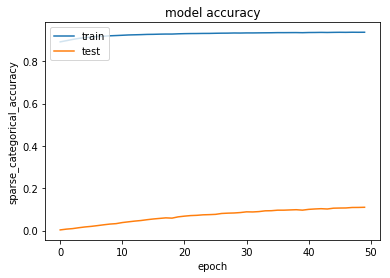

In [15]:

if history != None:
  # summarize history for accuracy
  plt.plot(history.history['val_sparse'])
  plt.plot(history.history['val_perfect'])
  plt.title('model accuracy')
  plt.ylabel('sparse_categorical_accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [22]:
short = x_test[0:1000]
predicts = None

with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  eval = model.evaluate(x_test, y_test)
  print('model.evaluate on val holdout: ' ,model.metrics_names, eval)
  print('history: ', history)
  predicts = model.predict(short, batch_size=32)
  print('shape: {}'.format(predicts.shape))

print(len(predicts[0]))
print(len(predicts[0][0]))
print(predicts[0])

  512/23906 [..............................] - ETA: 28s

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f721c1a97b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


23906/23906 [==============================] - 7s 303us/step
model.evaluate on val holdout:  ['loss', 'sparse', 'perfect'] [0.2577958069545379, 0.9370506702881223, 0.1100142223709529]
history:  <keras.callbacks.History object at 0x7f721c2e8cc0>


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f721c0d2550>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


shape: (1000, 30, 2000)
30
2000
[[5.9983528e-01 1.2863971e-01 2.6613809e-03 ... 4.5892266e-06
  5.6674867e-07 3.7716106e-07]
 [3.3188197e-01 8.3305672e-02 7.5759506e-04 ... 7.8412068e-06
  2.7797621e-06 5.1509435e-08]
 [6.8288404e-01 1.9245148e-02 1.7440571e-03 ... 1.7150329e-05
  7.4165632e-06 1.6640320e-07]
 ...
 [9.9998176e-01 3.6948803e-12 5.2141160e-12 ... 1.2295507e-07
  3.9898391e-09 2.9301377e-11]
 [9.9998164e-01 3.6674830e-12 5.0927084e-12 ... 1.2439719e-07
  3.9990731e-09 2.9754289e-11]
 [9.9998152e-01 3.6420806e-12 4.9842240e-12 ... 1.2573001e-07
  4.0077621e-09 3.0173655e-11]]


In [24]:
def maxindx(pred):
    maxi=-1
    maxv=-1.0
    for x in range(len(pred)):
        if pred[x] > maxv:
            maxv = pred[x]
            maxi = x
    return (maxi, maxv)

def match(data, prediction):
    good = 0
    total = 0
    for i in range(len(data)):
        if data[i] == np.argmax(prediction[i]):
            good += 1
        total += 1
    #print('{}, {}'.format(good, total))
    if (total == 0):
        return 0
    return good / total

parallel = 0.0
serial = 0.0
total = 0
for n in range(len(short)):
    print(len(short[n]))
    check = match(short[n], predicts[n])
    parallel += check
    if check > 0.9999:
        serial += 1
    total += 1

print('Parallel, serial: ', parallel / total, serial / total)


21
17
19
19
18
19
20
22
14
19
17
18
19
26
15
18
17
21
14
20
20
15
19
17
20
21
17
17
21
22
17
17
26
18
16
25
16
19
19
19
16
18
20
21
21
17
16
20
19
19
15
18
11
16
18
17
13
19
20
19
20
20
21
12
18
19
23
19
21
21
26
18
17
21
25
21
20
17
23
19
21
20
17
24
18
15
23
19
21
19
23
17
18
19
16
20
17
18
22
17
19
17
16
17
25
16
15
26
18
13
12
18
19
22
18
13
20
15
17
23
17
20
17
20
16
20
16
22
20
22
20
27
22
17
21
20
18
22
14
21
14
20
22
19
17
18
18
18
19
15
20
22
19
20
19
19
15
16
18
20
18
18
23
17
14
18
16
19
19
21
20
19
21
15
19
14
19
19
17
18
17
16
20
23
24
22
18
20
18
15
15
18
22
17
20
19
18
21
19
21
8
17
21
18
18
16
19
18
18
20
27
15
27
20
20
19
18
18
16
18
18
21
12
20
16
16
21
23
16
15
22
15
18
19
15
19
21
15
18
22
18
22
15
20
16
18
19
22
15
17
16
16
20
23
26
24
20
23
19
18
16
22
21
19
21
18
14
16
18
16
15
21
20
23
20
18
20
16
21
18
19
23
15
17
22
23
16
18
20
21
21
23
22
19
22
12
18
21
14
20
17
23
17
17
24
19
24
21
17
27
13
21
14
18
22
19
26
16
18
18
26
17
18
18
23
17
15
25
23
19
22
17
19
23